In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn

%load_ext google.cloud.bigquery

# 1. Load Data

In [2]:
%%bigquery df

WITH clean AS 
(
SELECT 
  DISTINCT full_visitor_id , client_id , organization_uuid , country_id , session_id , session_start_time , session_end_time ,
  session_reached_minimal_created , 
  traffic_source_level_3 , traffic_source_source, traffic_source_medium,
  COUNT(DISTINCT organization_uuid) OVER(PARTITION BY full_visitor_id ) as nr_unique_uuid
FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session` 
WHERE full_visitor_id NOT IN (--list of visitor id that has no client id and only one unique (NA) uuid and 
                          SELECT
                              full_visitor_id 
                          FROM (
                                SELECT
                                    DISTINCT full_visitor_id , client_id , organization_uuid  ,
                                    DENSE_RANK() OVER(PARTITION BY full_visitor_id ORDER BY client_id DESC, organization_uuid DESC) as rank_entry 
                                    #optimize the code by group by and array_agg()?
                                FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session` 
                                WHERE full_visitor_id IN (SELECT 
                                                            DISTINCT full_visitor_id
                                                          FROM `izettle-dp-pipeline-prod.legacy_views.google_analytics_session` 
                                                          WHERE client_id IS NULL AND organization_uuid IS NULL
                                                          )
                                #ORDER BY full_visitor_id , rank_entry
                                      )
                          WHERE rank_entry = 1
                          AND client_id IS NULL
                          AND organization_uuid IS NULL
                          ) 
), 
ga_processed AS (
--delete row with no uuid and nr_unique_uuid per group of visitor id of that row > 1 
-- and fill NA uuid cells (Expected: rows with NA uuid and nr_unique_uuid =0 left)--
SELECT 
  full_visitor_id , client_id , organization_uuid , 
  IFNULL(organization_uuid, MAX(organization_uuid) OVER(PARTITION BY full_visitor_id)) as fill_uuid ,
  country_id , session_id , session_start_time , session_end_time ,
  session_reached_minimal_created ,
  traffic_source_level_3 , traffic_source_source, traffic_source_medium,
  nr_unique_uuid
FROM clean
WHERE 
  organization_uuid IS NOT NULL
  OR
  (organization_uuid IS NULL AND nr_unique_uuid <= 1)
),
merged_campaign AS(
SELECT
  full_visitor_id , 
  IFNULL(fill_uuid, MAX(campaign_data.organization_uuid) OVER(PARTITION BY client_id)) as fill_uuid_2,
  country_id , session_id , session_start_time , session_end_time ,
  session_reached_minimal_created ,
  traffic_source_level_3, traffic_source_source, traffic_source_medium
FROM ga_processed
LEFT JOIN (SELECT
              DISTINCT google_analytics_id , organization_uuid 
           FROM `izettle-dp-pipeline-prod.legacy_views.user_campaign_data`
           WHERE google_analytics_id IN (
                                         SELECT DISTINCT google_analytics_id
                                         FROM `izettle-dp-pipeline-prod.legacy_views.user_campaign_data`
                                         GROUP BY google_analytics_id 
                                         HAVING COUNT(DISTINCT organization_uuid) = 1
                                         ) 
          ) AS campaign_data
ON ga_processed.client_id = campaign_data.google_analytics_id 
),
merged_oc AS (
--customer journey of merchants until registration tracked by ga cookies--
--only ~ 245,000 merchants have the recorded journey. The rest that we have only the last touch point can be found in the customer_acquisition table--
SELECT
  ft.fill_uuid_2 as organization_uuid , oc.organization_created ,
  ft.full_visitor_id, ft.country_id , ft.session_id , ft.session_start_time , ft.session_end_time ,
  ft.session_reached_minimal_created ,
  ft.traffic_source_level_3,
  traffic_source_source, traffic_source_medium
FROM merged_campaign ft
LEFT JOIN `izettle-dp-pipeline-prod.legacy_views.organization_customer` oc
ON ft.fill_uuid_2 =oc.organization_uuid 
WHERE fill_uuid_2 IS NOT NULL
AND oc.organization_created >= ft.session_start_time 
)
SELECT
  uuid_left.organization_uuid ,
  uuid_left.organization_created ,
  #uuid_left.traffic_source_level_3 as traffic_source_level_3_af ,
  #merged_oc.full_visitor_id, 
  uuid_left.country_id , 
  #merged_oc.session_id , merged_oc.session_start_time , merged_oc.session_end_time ,
  merged_oc.session_reached_minimal_created ,
  #merged_oc.traffic_source_level_3,
  #merged_oc.traffic_source_source, merged_oc.traffic_source_medium,
  IFNULL(merged_oc.traffic_source_level_3, uuid_left.traffic_source_level_3) as traffic_source_full
FROM (
      SELECT 
        af.organization_uuid,
        af.traffic_source_level_3 , oc.organization_created , oc.country_id
      FROM `izettle-dp-pipeline-prod.legacy_views.attribution_funnel_traffic_source` af
      JOIN `izettle-dp-pipeline-prod.legacy_views.organization_customer` oc
      ON af.organization_uuid = oc.organization_uuid 
      AND oc.organization_created >= '2017-09-01'
      ) as uuid_left
LEFT JOIN merged_oc
ON uuid_left.organization_uuid = merged_oc.organization_uuid 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1726549 entries, 0 to 1726548
Data columns (total 5 columns):
organization_uuid                  object
organization_created               datetime64[ns, UTC]
country_id                         object
session_reached_minimal_created    object
traffic_source_full                object
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 65.9+ MB


Load all uuid that do not have last touch point in GA

In [4]:
%%bigquery df_af
SELECT 
  af.organization_uuid,
  oc.organization_created,
  oc.country_id,
  af.traffic_source_level_3 as traffic_source_full
FROM `izettle-dp-pipeline-prod.legacy_views.attribution_funnel_traffic_source` af
JOIN `izettle-dp-pipeline-prod.legacy_views.organization_customer` oc
ON oc.organization_uuid = af.organization_uuid
WHERE oc.organization_created >= '2017-09-01'            

In [5]:
df_af.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1130099 entries, 0 to 1130098
Data columns (total 4 columns):
organization_uuid       1130099 non-null object
organization_created    1130099 non-null datetime64[ns, UTC]
country_id              1130099 non-null object
traffic_source_full     1130099 non-null object
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 34.5+ MB


# 2. Data Preparation

Some uuid (from GA tracking) cannt be traced the last touch point in GA. Pulling these last touch point from attribution_funnel


In [6]:
df_concat_1 = df[df['session_reached_minimal_created'].isna()]
df_concat_2 = df[df['session_reached_minimal_created'] == True] #duplicate here
df_concat_2 = df_concat_2.drop_duplicates('organization_uuid')

In [7]:
last_touch_ls = list(df_concat_2['organization_uuid'].unique()) + list(df_concat_1['organization_uuid'].unique())


In [16]:
df_concat_3 = df_af[~df_af['organization_uuid'].isin(last_touch_ls)]

In [9]:
df_concat_1 = df_concat_1.drop('session_reached_minimal_created', axis=1)
df_concat_2= df_concat_2.drop('session_reached_minimal_created', axis=1)

In [17]:
print(df_concat_1.info())
print(df_concat_2.info())
print(df_concat_3.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 430615 entries, 7 to 1726547
Data columns (total 4 columns):
organization_uuid       430615 non-null object
organization_created    430615 non-null datetime64[ns, UTC]
country_id              430615 non-null object
traffic_source_full     430615 non-null object
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 16.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 659613 entries, 1 to 1726548
Data columns (total 4 columns):
organization_uuid       659613 non-null object
organization_created    659613 non-null datetime64[ns, UTC]
country_id              659613 non-null object
traffic_source_full     659613 non-null object
dtypes: datetime64[ns, UTC](1), object(3)
memory usage: 25.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 39871 entries, 1 to 1130024
Data columns (total 4 columns):
organization_uuid       39871 non-null object
organization_created    39871 non-null datetime64[ns, UTC]
country_id           

In [18]:
basetable = pd.concat([df_concat_1, df_concat_2, df_concat_3], axis = 0, ignore_index=True)

In [19]:
list(basetable.traffic_source_full.unique())

['ds_inbound_inbound',
 'ds_keyaccount_keyaccount',
 'ps_other_partner',
 'o_paid_sem',
 'ps_bank_bank',
 'o_organic_app',
 'o_organic_seo',
 'o_paid_social',
 'o_organic_null',
 'o_organic_direct',
 'o_organic_invite',
 'o_paid_affiliate',
 'o_organic_referral',
 'o_paid_app_install',
 'ps_other_isc',
 'pp_paypal_paypal',
 'ps_product_api',
 'ps_other_local_partnership',
 'ps_pay_sdk',
 'ds_keyaccount_sdk']

In [20]:
dict_channels = {'ps_pay_sdk':'partnerships', 'ps_product_api':'partnerships', 'ps_bank_bank':'partnerships',
                'ps_other_local_partnership':'partnerships', 'ps_other_partner':'partnerships',
                 'ps_other_isc':'partnerships', 'pp_paypal_paypal':'partnerships',
                'ds_inbound_inbound':'direct','ds_keyaccount_sdk':'direct','ds_keyaccount_keyaccount':'direct'}

def map_value(df):
    df['traffic_source'] = ''
    for i in range(0, df.shape[0]):
        if df.traffic_source_full.iloc[i] in list(dict_channels.keys()):
            df['traffic_source'].iat[i] = dict_channels[df.traffic_source_full.iloc[i]]
        else: df['traffic_source'].iat[i] = df['traffic_source_full'].iat[i]

In [21]:
map_value(basetable)

In [22]:
basetable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1130099 entries, 0 to 1130098
Data columns (total 5 columns):
organization_uuid       1130099 non-null object
organization_created    1130099 non-null datetime64[ns, UTC]
country_id              1130099 non-null object
traffic_source_full     1130099 non-null object
traffic_source          1130099 non-null object
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 43.1+ MB


In [23]:
basetable.tail()

,organization_uuid,organization_created,country_id,traffic_source_full,traffic_source
1130094,d665be40-4955-11e8-b7dd-a2dcd575060b,2018-04-26 13:29:25.284000+00:00,SE,o_paid_app_install,o_paid_app_install
1130095,813a7170-bc1b-11e8-967c-31dc3fabaf79,2018-09-19 14:51:35.303000+00:00,SE,o_paid_app_install,o_paid_app_install
1130096,28d38190-ba1c-11e7-b40e-5449234c906f,2017-10-26 07:06:16.489000+00:00,SE,o_paid_app_install,o_paid_app_install
1130097,cf4eee70-5f02-11e8-b010-14341e7c8bb4,2018-05-24 03:30:30.743000+00:00,SE,o_paid_app_install,o_paid_app_install
1130098,c31a7b80-9efc-11e8-b801-d46864203fa6,2018-08-13 13:28:27.704000+00:00,SE,o_paid_app_install,o_paid_app_install


In [24]:
basetable['organization_uuid'].nunique()

1130087

# 3. Last touch Model

## 3.1 Global

In [36]:
def last_touch(df):
    df_model = pd.DataFrame(df.traffic_source.value_counts())
    df_model.columns = ['conversion_abs']
    df_model['conversion_rate'] = df_model['conversion_abs']/df_model['conversion_abs'].sum()
    
    
    fig = plt.figure(figsize = (10,8))

    fig.add_subplot(2,1,1)
    plt.barh(y = df_model.index, width = 'conversion_rate', data = df_model, color = sbn.color_palette('tab20'))
    plt.title('Last touch attribution model')
    plt.xlabel('conversion rate')

    fig.add_subplot(2,1,2)
    plt.barh(y = df_model.index, width = 'conversion_abs', data = df_model, color = 'slateblue')
    plt.xlabel('abs number of conversion')

    plt.show()
    return df_model

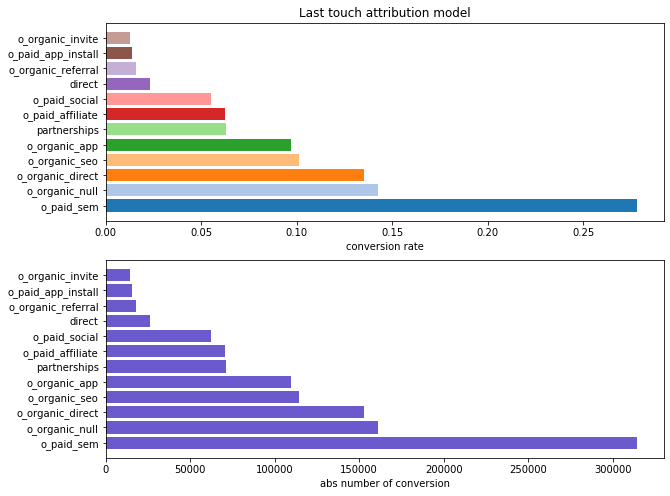

In [40]:
df_model = last_touch(basetable)

In [81]:
df_model

,conversion_abs,conversion_rate
o_paid_sem,314471,0.278269
o_organic_null,161171,0.142617
o_organic_direct,152567,0.135003
o_organic_seo,114256,0.101103
o_organic_app,109410,0.096815
partnerships,70995,0.062822
o_paid_affiliate,70708,0.062568
o_paid_social,62389,0.055207
direct,26082,0.023079
o_organic_referral,18117,0.016031


In [31]:
uuid_trackable_ga = list(df_concat_2['organization_uuid'].unique()) + list(df_concat_3['organization_uuid'].unique())

In [32]:
basetable_only_ga = basetable[basetable['organization_uuid'].isin(uuid_trackable_ga)]

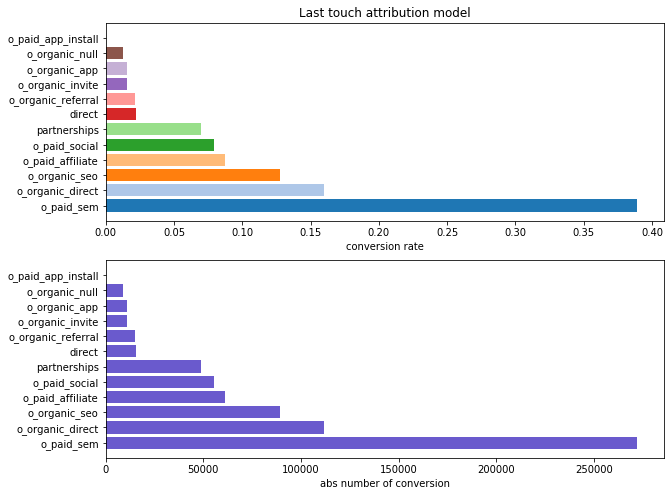

In [39]:
df_model_only_ga = last_touch(basetable_only_ga)

In [46]:
100*(df_model[['conversion_rate']].sort_index() - df_model_only_ga[['conversion_rate']].sort_index())

,conversion_rate
direct,0.079725
o_organic_app,8.144748
o_organic_direct,-2.503332
o_organic_invite,-0.321541
o_organic_null,13.013894
o_organic_referral,-0.517286
o_organic_seo,-2.632271
o_paid_affiliate,-2.445618
o_paid_app_install,1.342047
o_paid_sem,-11.084543


## 3.2 Monthly Basic

In [47]:
basetable_m = basetable.assign(year_month = basetable.organization_created.dt.to_period('M'))

//anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [48]:
basetable_m.head()

,organization_uuid,organization_created,country_id,traffic_source_full,traffic_source,year_month
0,28f9c6b0-d9b7-11e7-a769-14a76c0df6d1,2017-12-05 12:23:54.779000+00:00,IT,ds_inbound_inbound,direct,2017-12
1,20bfe2a0-ca20-11e7-aa13-9821d1e27854,2017-11-15 16:14:59.530000+00:00,IT,ds_inbound_inbound,direct,2017-11
2,5ac103a0-1c8f-11e8-9451-d9280659f68d,2018-02-28 13:57:46.330000+00:00,IT,ds_inbound_inbound,direct,2018-02
3,1cdfd4d0-ff7f-11e7-846d-7aeb7d92f669,2018-01-22 14:18:26.845000+00:00,IT,ds_inbound_inbound,direct,2018-01
4,8d243380-d0fe-11e7-8e34-7d89207b4112,2017-11-24 10:02:16.632000+00:00,IT,ds_inbound_inbound,direct,2017-11


In [53]:
def last_touch_m(df):
    df_group = pd.DataFrame(df.groupby('year_month')['traffic_source'].value_counts().unstack()).fillna(0)
    
    df_base = df_group.merge(pd.DataFrame(df_group.sum(axis = 1)),
                                      how = 'left',
                                      on = 'year_month')
    
    df_base.rename(columns = {0:'total_conversion'}, inplace = True)
    df_base.reset_index(inplace = True)
    
    base = pd.melt(df_base, id_vars = ['year_month','total_conversion'])
    base['conversion_rate'] = base['value']/base['total_conversion']
    
    return base.pivot(index = 'year_month', columns = 'variable', values = 'conversion_rate')
    

In [54]:
last_touch_m = last_touch_m(basetable_m)

In [55]:
last_touch_m

variable,direct,o_organic_app,o_organic_direct,o_organic_invite,o_organic_null,o_organic_referral,o_organic_seo,o_paid_affiliate,o_paid_app_install,o_paid_sem,o_paid_social,partnerships
year_month,,,,,,,,,,,,
2017-09,0.029715,0.010976,0.262351,0.032295,0.092918,0.016792,0.102969,0.046289,0.000462,0.239815,0.072110,0.093307
2017-10,0.033891,0.006649,0.301875,0.033195,0.024242,0.020930,0.109738,0.050332,0.000768,0.271536,0.079519,0.067326
2017-11,0.039631,0.009740,0.312750,0.032509,0.023884,0.020009,0.101098,0.054161,0.000791,0.258487,0.064835,0.082104
2017-12,0.023976,0.011017,0.334618,0.025670,0.024768,0.018344,0.088657,0.039668,0.000629,0.250991,0.090380,0.091282
2018-01,0.022070,0.013431,0.307746,0.023183,0.024345,0.016383,0.096581,0.046149,0.000944,0.288992,0.080875,0.079302
2018-02,0.023111,0.014727,0.303816,0.025397,0.022485,0.015652,0.107225,0.047174,0.000572,0.301094,0.065494,0.073252
2018-03,0.028947,0.019995,0.288212,0.024669,0.045594,0.016996,0.108161,0.066357,0.000419,0.271007,0.062753,0.066891
2018-04,0.022038,0.120415,0.139551,0.027703,0.105792,0.014116,0.108601,0.059551,0.005458,0.297041,0.031549,0.068187
2018-05,0.019654,0.154058,0.062258,0.020462,0.144066,0.014326,0.119395,0.055230,0.014367,0.287986,0.050026,0.058174


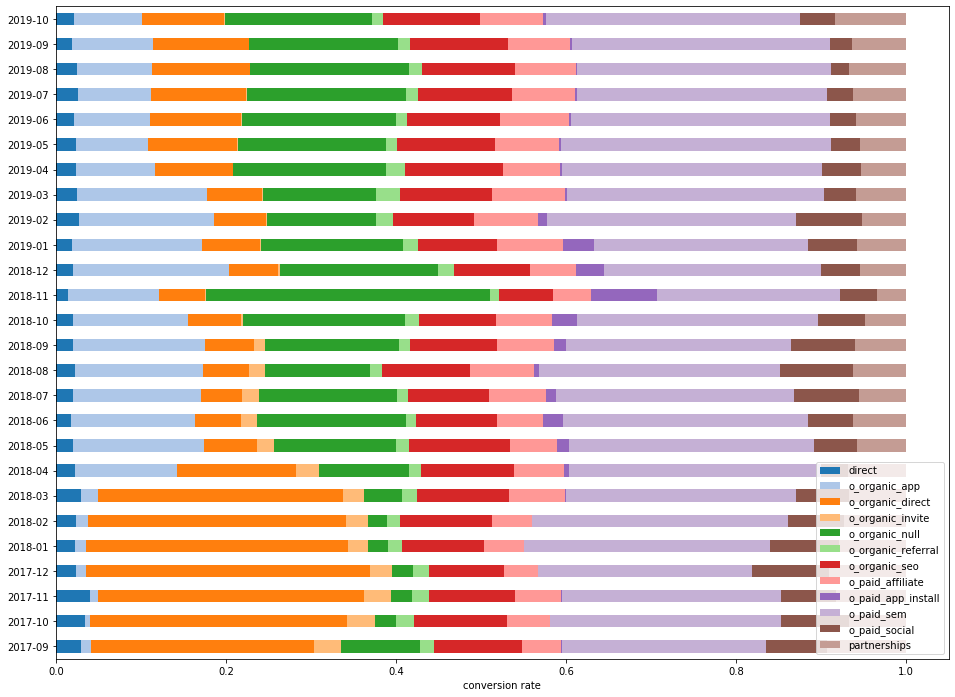

In [56]:
last_touch_m.plot.barh(stacked = True,
                         rot = 0,
                         figsize = (16,12),
                          color = sbn.color_palette('tab20'))
plt.xlabel('conversion rate')
plt.ylabel('')
plt.legend(loc = 'lower right')
plt.show()

## 3.3 Markets

In [57]:
country_list = basetable_m.country_id.unique()

In [58]:
country_list_main = ['BR', 'GB', 'FR', 'MX', 'FI', 'NO', 'ES', 'NL', 'DE', 'DK', 'IT', 'SE']

In [59]:
def last_touch_markets(df):
    for i in country_list_main:
        table = df[df['country_id'] == i]
        print(i)
        last_touch(table)

BR


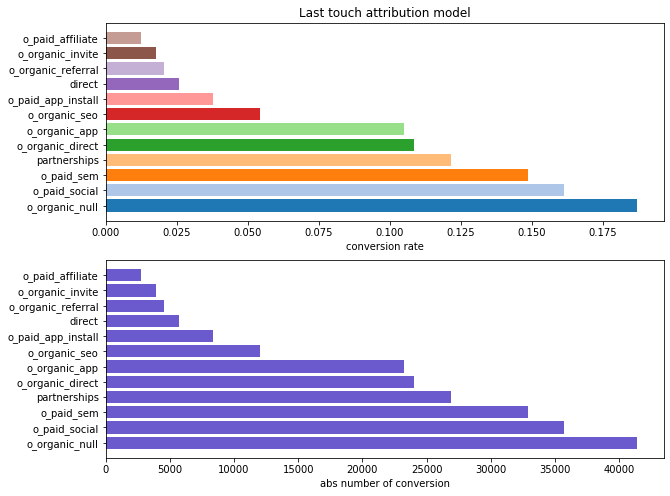

GB


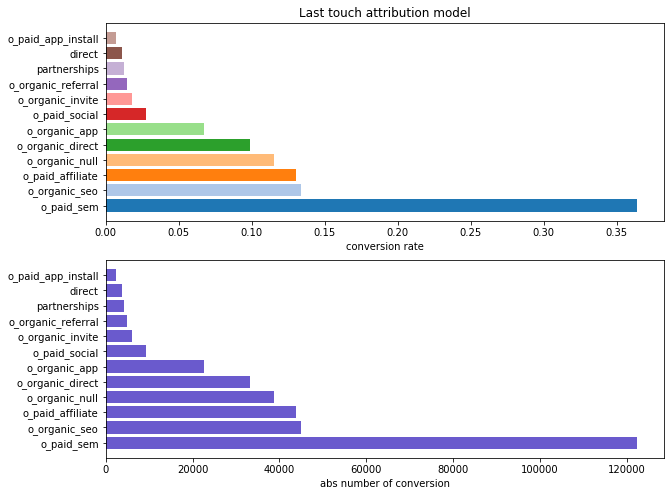

FR


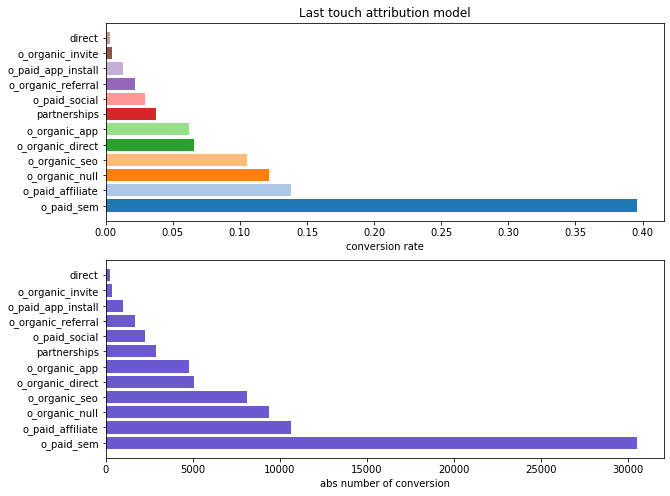

MX


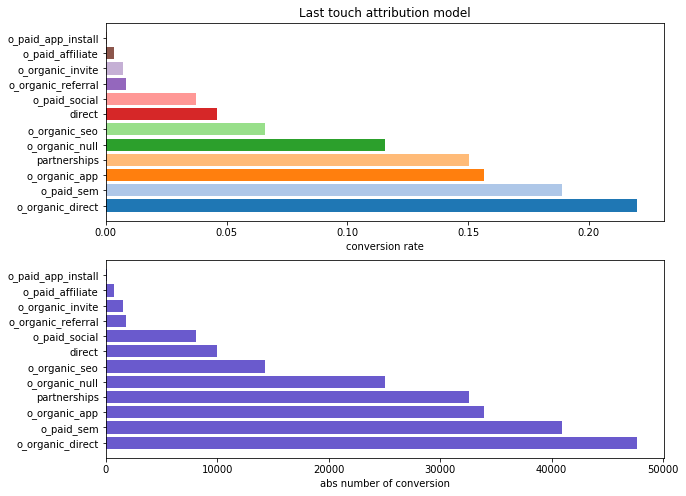

FI


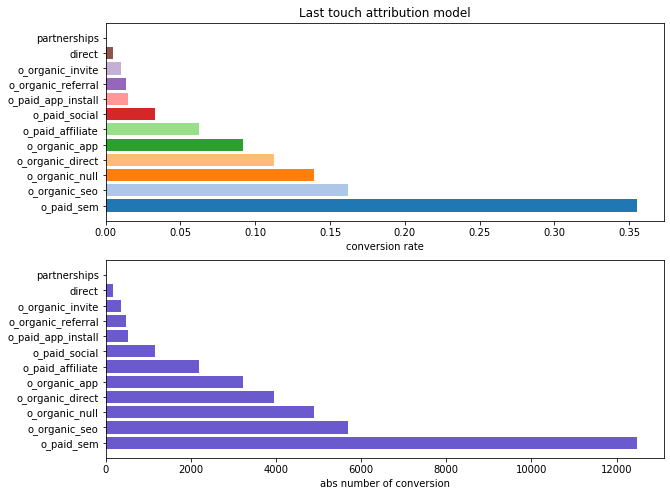

NO


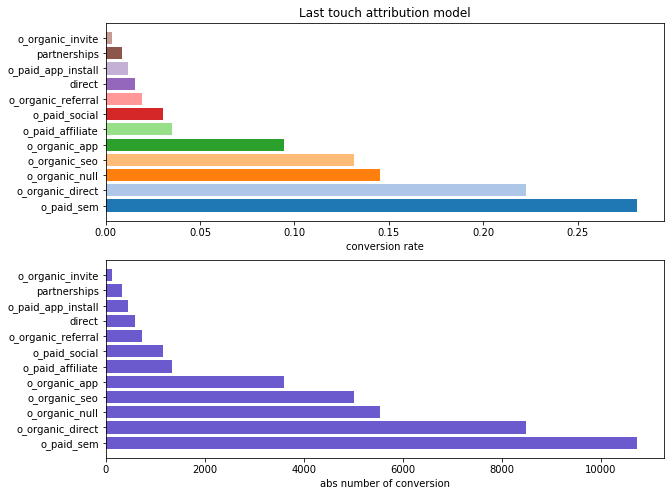

ES


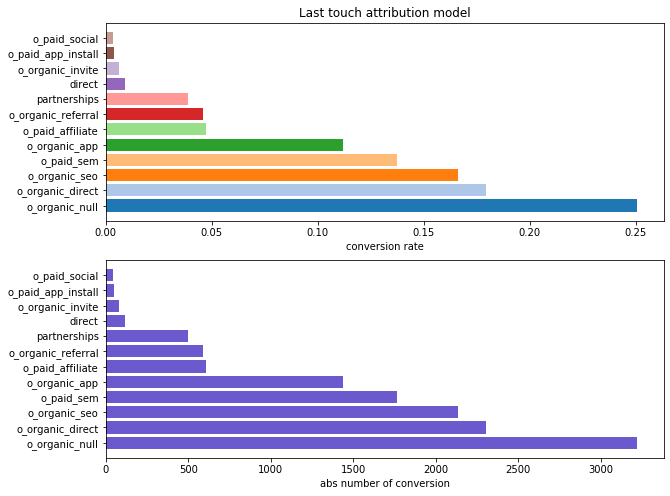

NL


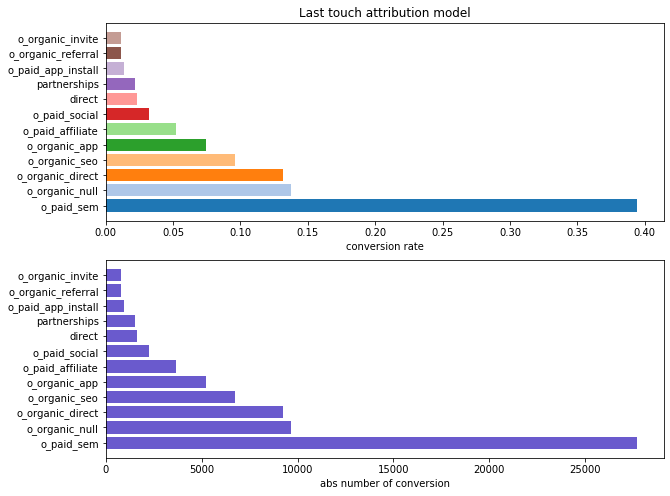

DE


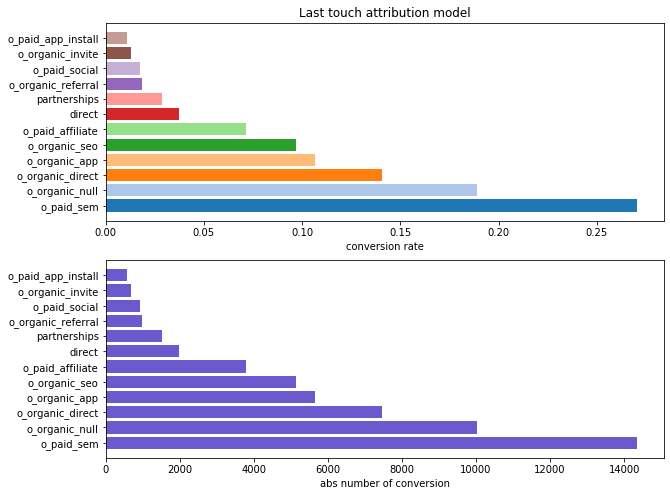

DK


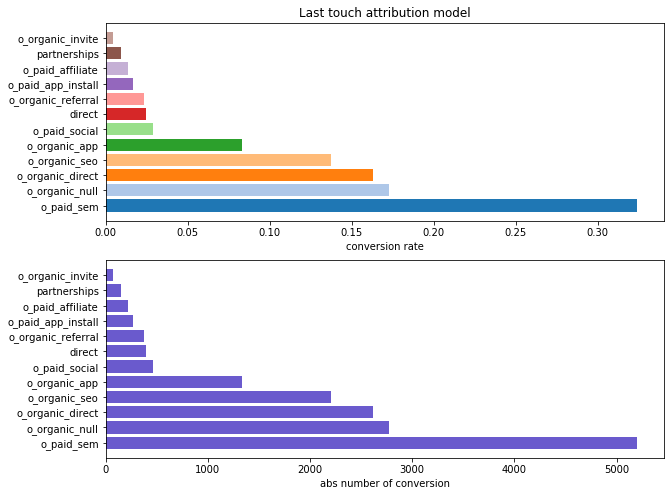

IT


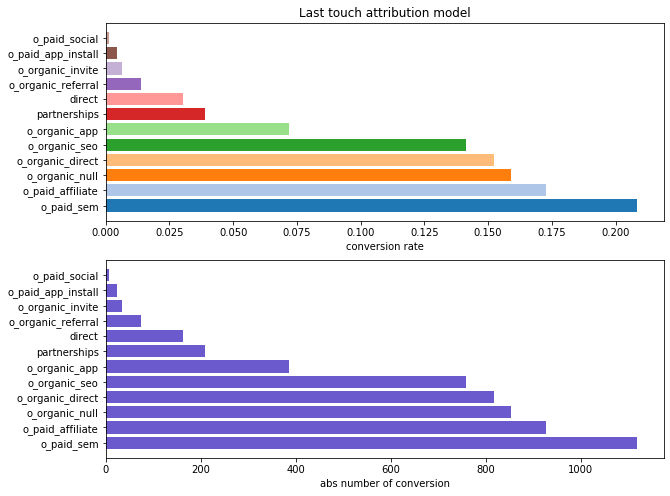

SE


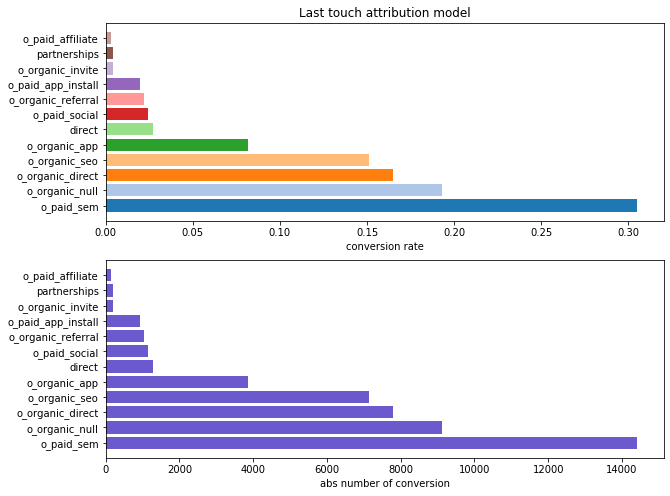

In [60]:
last_touch_markets(basetable_m)

## 3.4 Europe

In [66]:
country_list_euro = ['GB', 'FR', 'FI', 'NO', 'ES', 'NL', 'DE', 'DK', 'IT', 'SE']
basetable_europe = basetable[basetable['country_id'].isin(country_list_euro)]

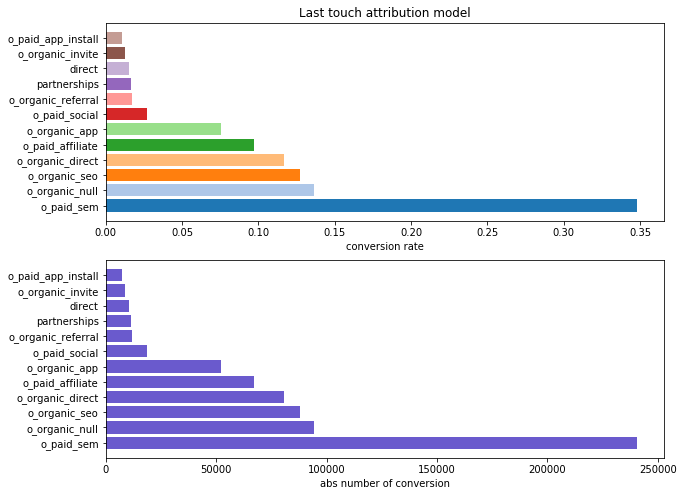

In [70]:
df_model_euro = last_touch(basetable_europe)

## 3.5 Monthly basic and Markets

In [73]:
def last_touch_m(df):
    df_group = pd.DataFrame(df.groupby('year_month')['traffic_source'].value_counts().unstack()).fillna(0)
    
    df_base = df_group.merge(pd.DataFrame(df_group.sum(axis = 1)),
                                      how = 'left',
                                      on = 'year_month')
    
    df_base.rename(columns = {0:'total_conversion'}, inplace = True)
    df_base.reset_index(inplace = True)
    
    base = pd.melt(df_base, id_vars = ['year_month','total_conversion'])
    base['conversion_rate'] = base['value']/base['total_conversion']
    
    return base.pivot(index = 'year_month', columns = 'variable', values = 'conversion_rate')

In [74]:
def last_touch_markets(df):
    for i in country_list_main:
        table = df[df['country_id'] == i]
        title = i
        
        last_touch = last_touch_m(table)
        
        pal = sbn.color_palette("tab20")
        last_touch.plot.barh(stacked = True,
                         rot = 0, colors = pal,
                         figsize = (14,10))
        plt.xlabel('conversion rate')
        plt.ylabel('')
        plt.xlabel('')
        plt.legend(loc = 'upper right')
        plt.title(title)
        plt.show()

//anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


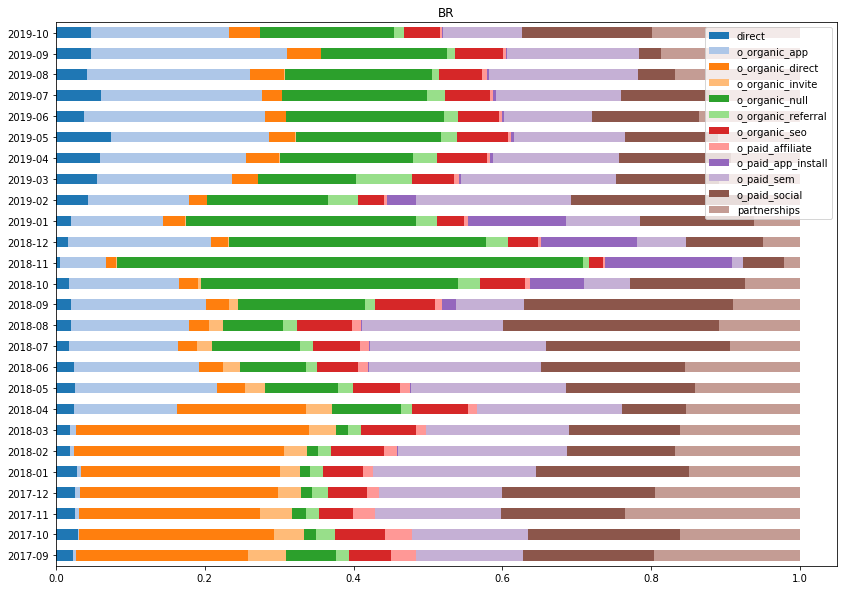

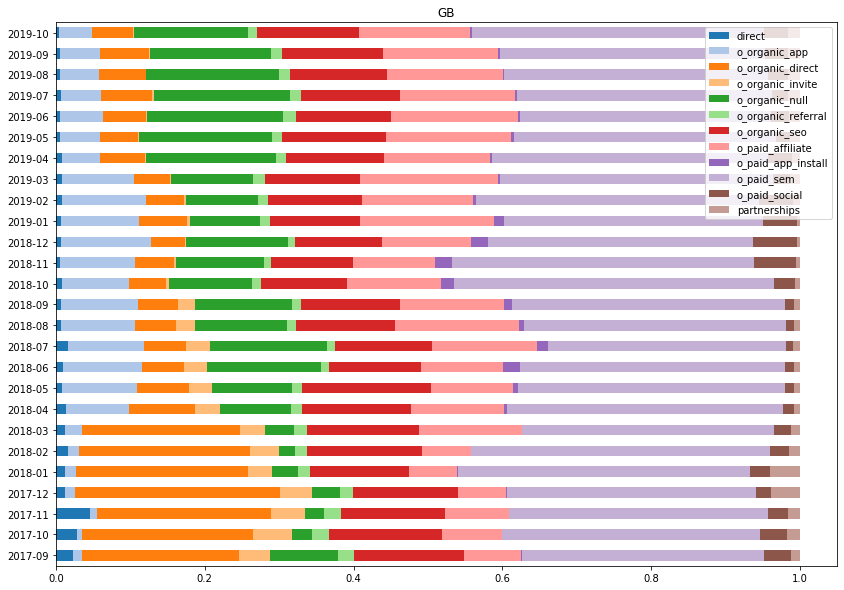

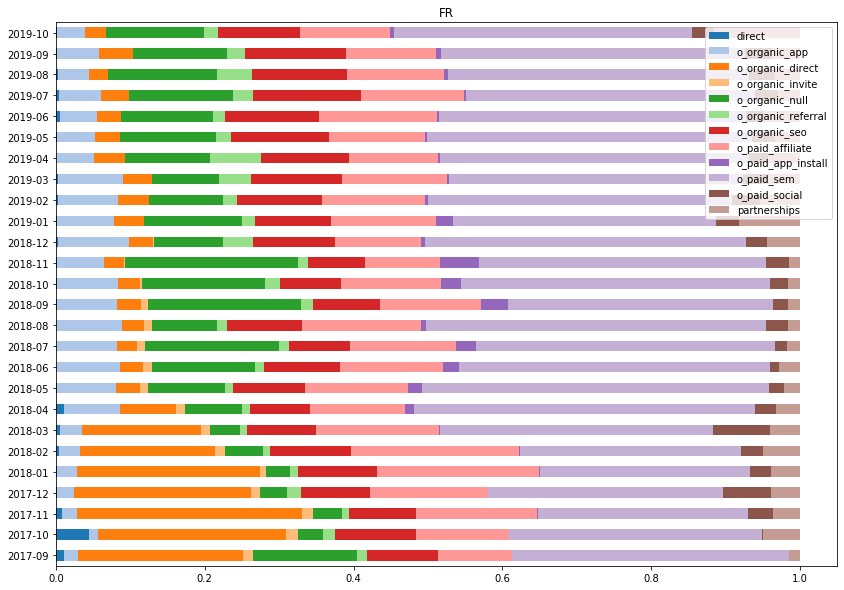

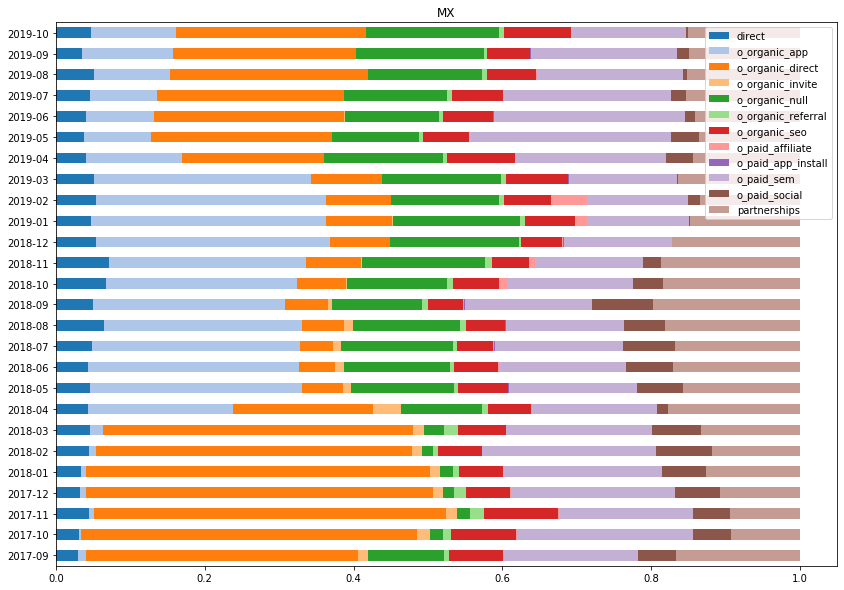

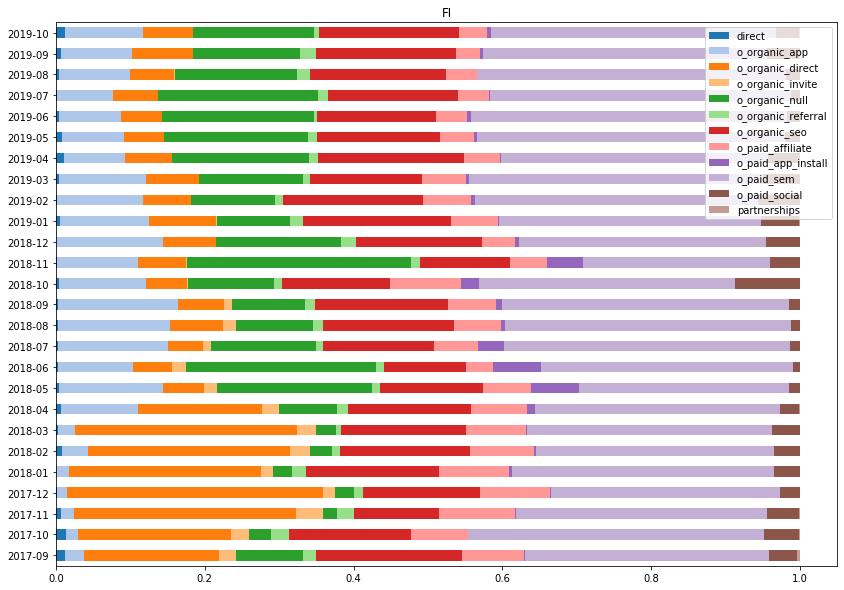

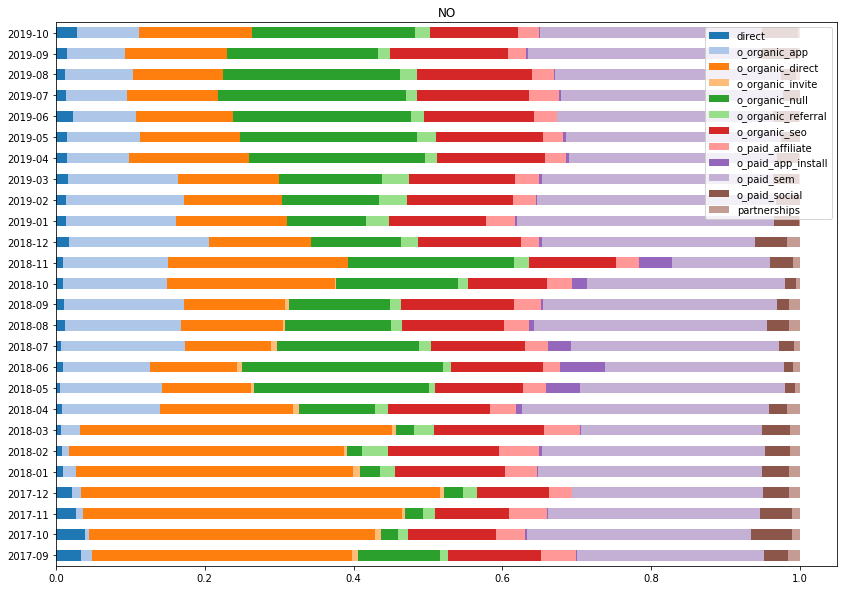

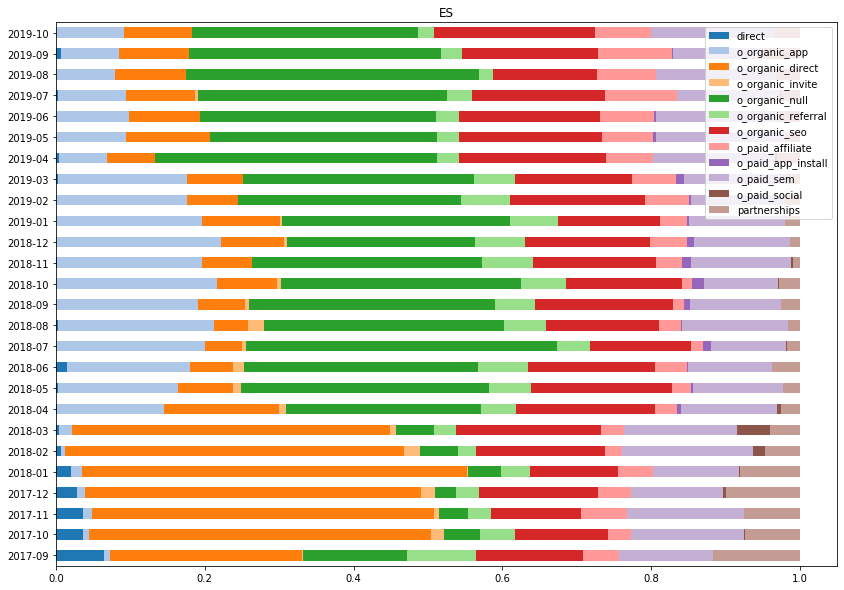

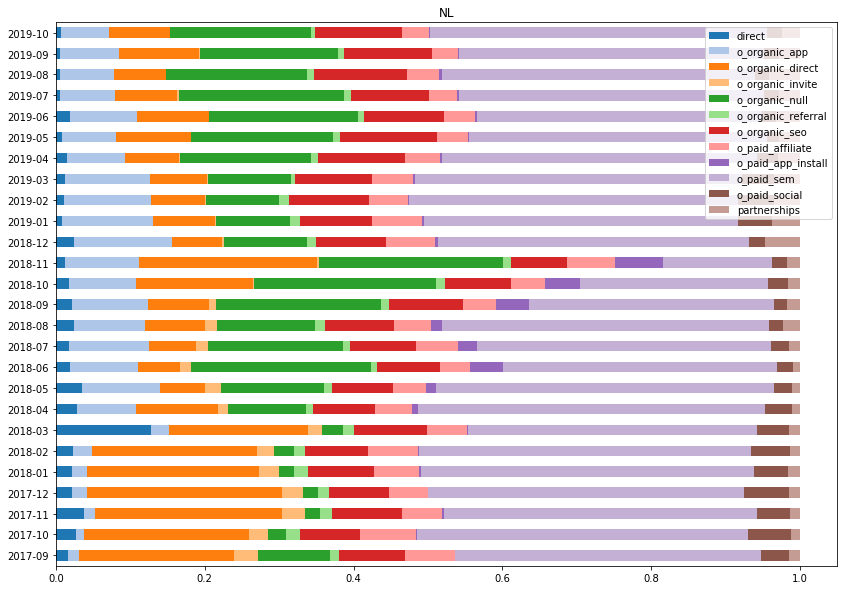

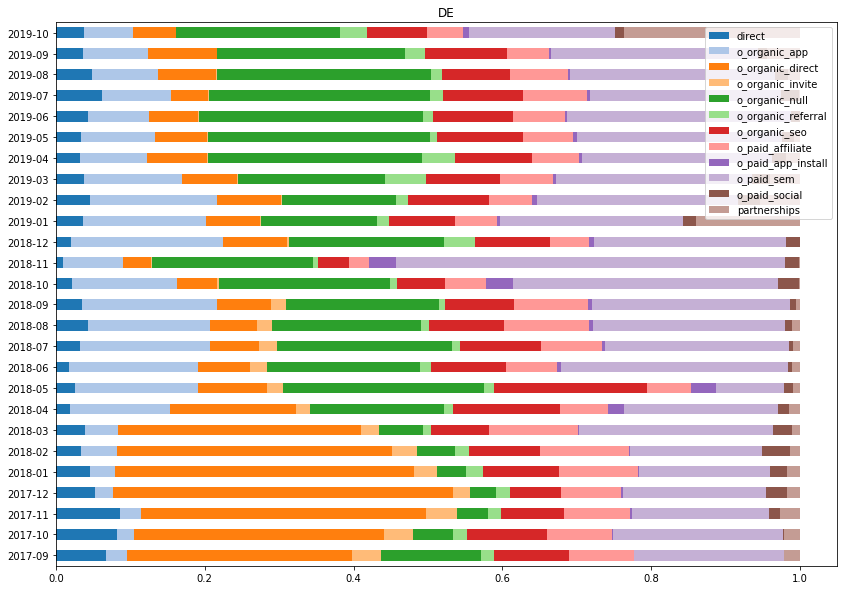

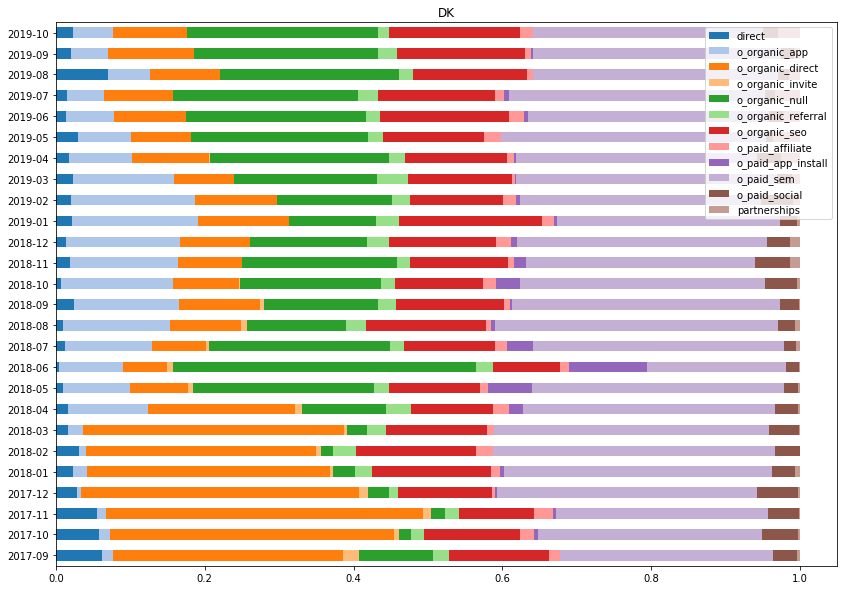

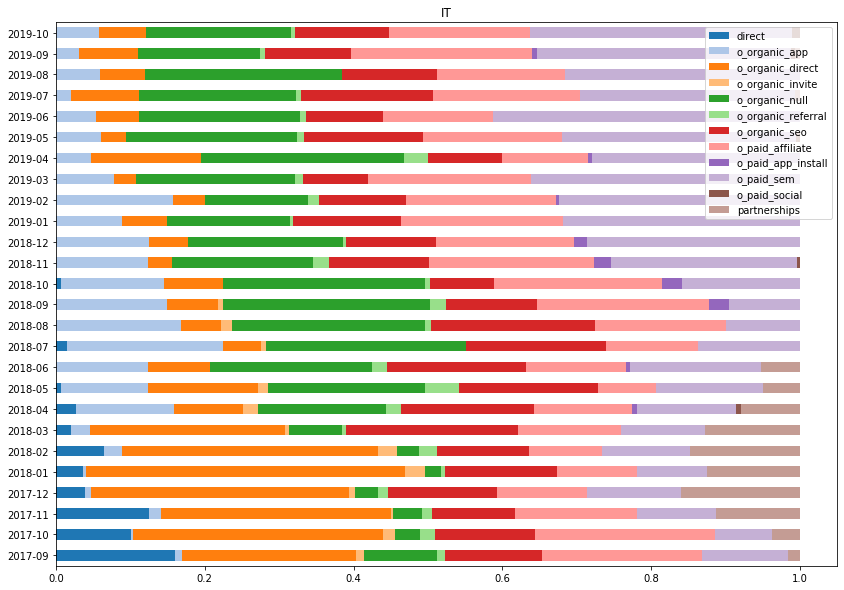

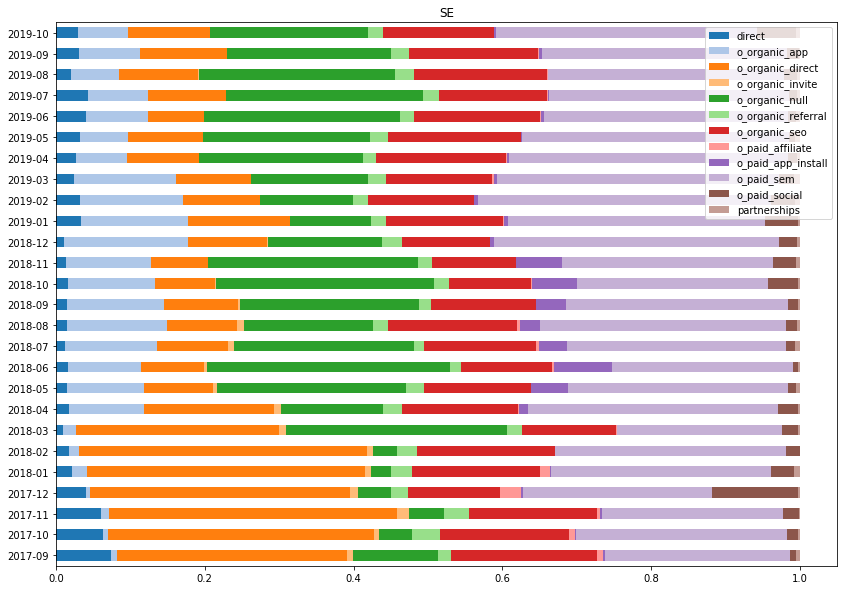

In [75]:
last_touch_markets(basetable_m)

## 3.6 Monthly basic and Europe

In [76]:
basetable_europe_m = basetable_europe.assign(year_month = basetable.organization_created.dt.to_period('M'))

//anaconda3/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [78]:
europe_m = last_touch_m(basetable_europe_m)

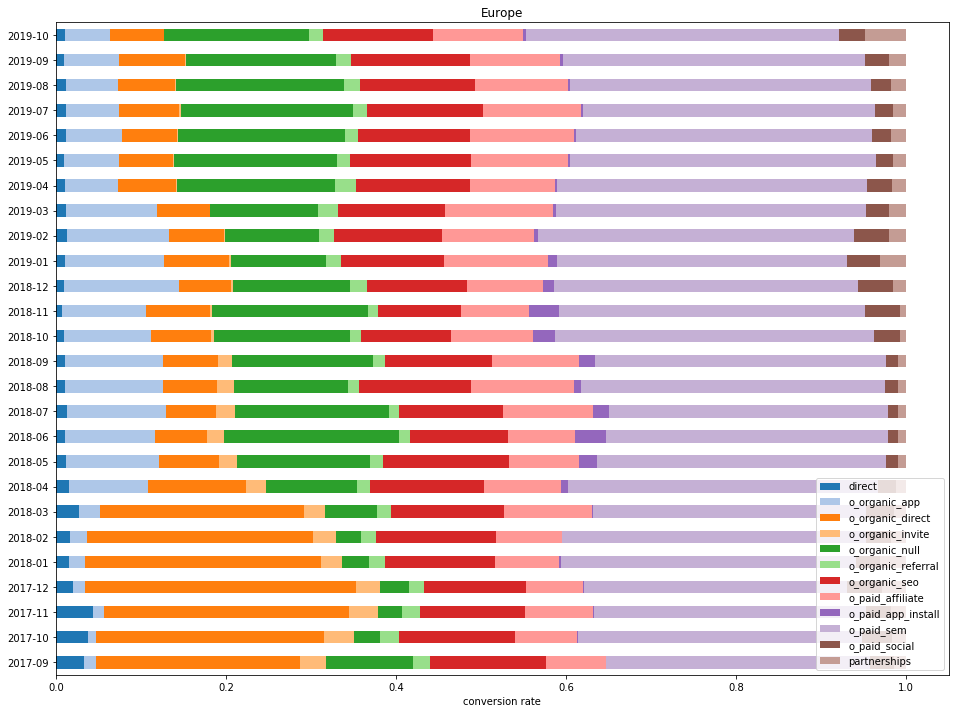

In [80]:
europe_m.plot.barh(stacked = True,
                         rot = 0,
                         figsize = (16,12),
                          color = sbn.color_palette('tab20'))
plt.xlabel('conversion rate')
plt.ylabel('')
plt.legend(loc = 'lower right')
plt.title('Europe')
plt.show()